In [24]:
import numpy as np
from TTT_Minimax import findBestMove
from utils import stringfy, check_victory, get_legal_actions, get_all_states_tic_tac_toe, \
                get_max_for_specific_indexes, convert_compact_to_matrix

import pickle

import networkx as nx

import matplotlib.pyplot as plt

In [ ]:
INDEX_STATE = get_all_states_tic_tac_toe()
AI = 1
HUMAN = 2

In [ ]:
#perfect_table = {}
#i = 0
#for el in INDEX_STATE:
#    matrix = convert_compact_to_matrix(el)
#    perfect_table[el] = findBestMove(matrix)
#    i += 1
#    if i%1000 == 0:
#        print("Episode: ",i)

In [ ]:
# save the dictionary to a file
#with open('perfect_table.pickle', 'wb') as handle:
#    pickle.dump(perfect_table, handle)

In [ ]:
# load the dictionary from a file
with open('perfect_table.pickle', 'rb') as handle:
    perfect_table = pickle.load(handle)

In [ ]:

class TTToe():
    def __init__(self):
        self.config = np.zeros((3,3),dtype=int)
        self.done = False
        

    def reset(self):
        self.config = np.zeros((3,3),dtype=int)
        self.done = False
        return np.argwhere(INDEX_STATE== stringfy(self.config))[0][0]

        
    def action_space(self):
        return 9

    def get_legal_actions(self):
        couples = np.argwhere(self.config == 0)
        return np.array([t[0]*3+t[1] for t in couples])
    
    def get_state(self):
        return np.argwhere(INDEX_STATE== stringfy(self.config))[0][0]
        
    def step(self,action,player = AI):
        if self.done:
            raise Exception("Game is over")
        
        i = action//3
        j = action%3
        if self.config[i][j] != 0:
            raise Exception("Invalid Action")
            
        self.config[i][j] = player
        state = np.argwhere(INDEX_STATE== stringfy(self.config))[0][0]

        result = check_victory(self.config)
        
        if result == AI:
            # ai victory
            self.done = True
            return state, 1, self.done
        elif result == HUMAN:
            # human victory
            self.done = True
            return state, -1, self.done
        else:
            # draw
            if np.all(self.config != 0):
                self.done = True
                return state, 0, self.done
            # not ended
            else:
                return state, 0, self.done
        
        
    def render(self):
        print(self.config)

In [ ]:
class QTable():
    def __init__(self,env,eps,alpha,gamma):
        self.env = env
        self.q_table = np.zeros((np.power(3,9),env.action_space()))
        self.eps = eps
        self.alpha = alpha
        self.gamma = gamma

    def backpropagate(self,state_history,reward):
        for state,action in reversed(state_history):
            self.q_table[state,action] += self.alpha*(self.gamma * reward - self.q_table[state,action])
            reward = self.q_table[state,action]

    def train(self,num_episodes):
        for i in range(num_episodes):
            state = self.env.reset()
            state_history = []
            done = False
            while not done:
                
                if np.random.random() < self.eps:
                    # random action
                    action = np.random.choice(self.env.get_legal_actions())
                else:
                    # greedy action
                    legal_actions = self.env.get_legal_actions()
                    action = get_max_for_specific_indexes(self.q_table[state],legal_actions)
                
                state_history.append((state,action))

                new_state,reward,done = self.env.step(action)
                if not self.env.done:
                    if np.random.random() > 1:
                        action_opponent =  perfect_table[INDEX_STATE[new_state]] #findBestMove(self.env.config)
                    else:
                        action_opponent = np.random.choice(self.env.get_legal_actions())
                    new_state, reward, done = self.env.step(action_opponent, player=HUMAN)
                state = new_state
                

            self.backpropagate(state_history,reward)
                
            if i%1000 == 0:
                print("Episode: ",i)

In [ ]:
env = TTToe()
q_table = QTable(env,eps = 0.2,alpha = 0.1,gamma = 0.9)

In [ ]:
q_table.train(20_000)

In [ ]:
q_table.q_table[0].argmax()

In [ ]:
ai_wins = 0
human_wins = 0
for i in range(1000):
    state = env.reset()
    done = False
    while not done:
        legal_actions = env.get_legal_actions()
        max_val = -np.inf
        for x in legal_actions:
            if q_table.q_table[state,x] > max_val:
                max_val = q_table.q_table[state,x]
                action = x

        state, _, done = env.step(action)
        if not env.done:
            if np.random.random() < 0:
                action = np.random.choice(env.get_legal_actions())
            else:
                action = perfect_table[stringfy(env.config)]
            #action = int(input())
            state, _, done = env.step(action,2)
        if env.done:
            if check_victory(env.config) == 1:
                ai_wins += 1
            elif check_victory(env.config) == 2:
                human_wins += 1

    #if i%10 == 0:
    #    print("Episode: ",i)
print('\n\n')
print("AI wins: ", ai_wins)
print("Human wins: ", human_wins)

In [ ]:
# save the q_values to a file
#with open('q_table.pickle', 'wb') as handle:
#    pickle.dump(q_table.q_table, handle)

In [ ]:
with open('q_table.pickle', 'rb') as handle:
    table = pickle.load(handle)

In [60]:
table[6561]

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [58]:
np.argmax(table[0])

0

246

In [148]:
np.argwhere(INDEX_STATE=='210201120')

array([[15837]])

In [149]:
np.argmax(table[15837])

0

In [134]:
def convert_to_adiacencies(table):
    m = table.shape[0]
    A = np.zeros((m,m))
    for i in range(m):
        if table[i,:].sum()==0:
            continue
        action = np.argmax(table[i,:])
        state = convert_compact_to_matrix(INDEX_STATE[i])
        row = action//3
        col = action%3
        state[row,col] = AI
        j = np.argwhere(INDEX_STATE== stringfy(state))
        A[i,j] = 1
        # get (r,s) from state that contains a 0
        couples = np.argwhere(state == 0)
        if couples.shape[0] == 0:
            continue
        r,s = couples[np.random.choice(range(couples.shape[0]))]
        state[r,s] = HUMAN
        w = np.argwhere(INDEX_STATE== stringfy(state))
        A[j,w] = 1

            
    return A
        

A = convert_to_adiacencies(table)


In [135]:
# create the graph, use INDEX_STATE as labels
G = nx.from_numpy_array(A, create_using=nx.DiGraph)
G = nx.relabel_nodes(G, dict(zip(range(len(INDEX_STATE)), INDEX_STATE)))
G.remove_nodes_from(list(nx.isolates(G)))

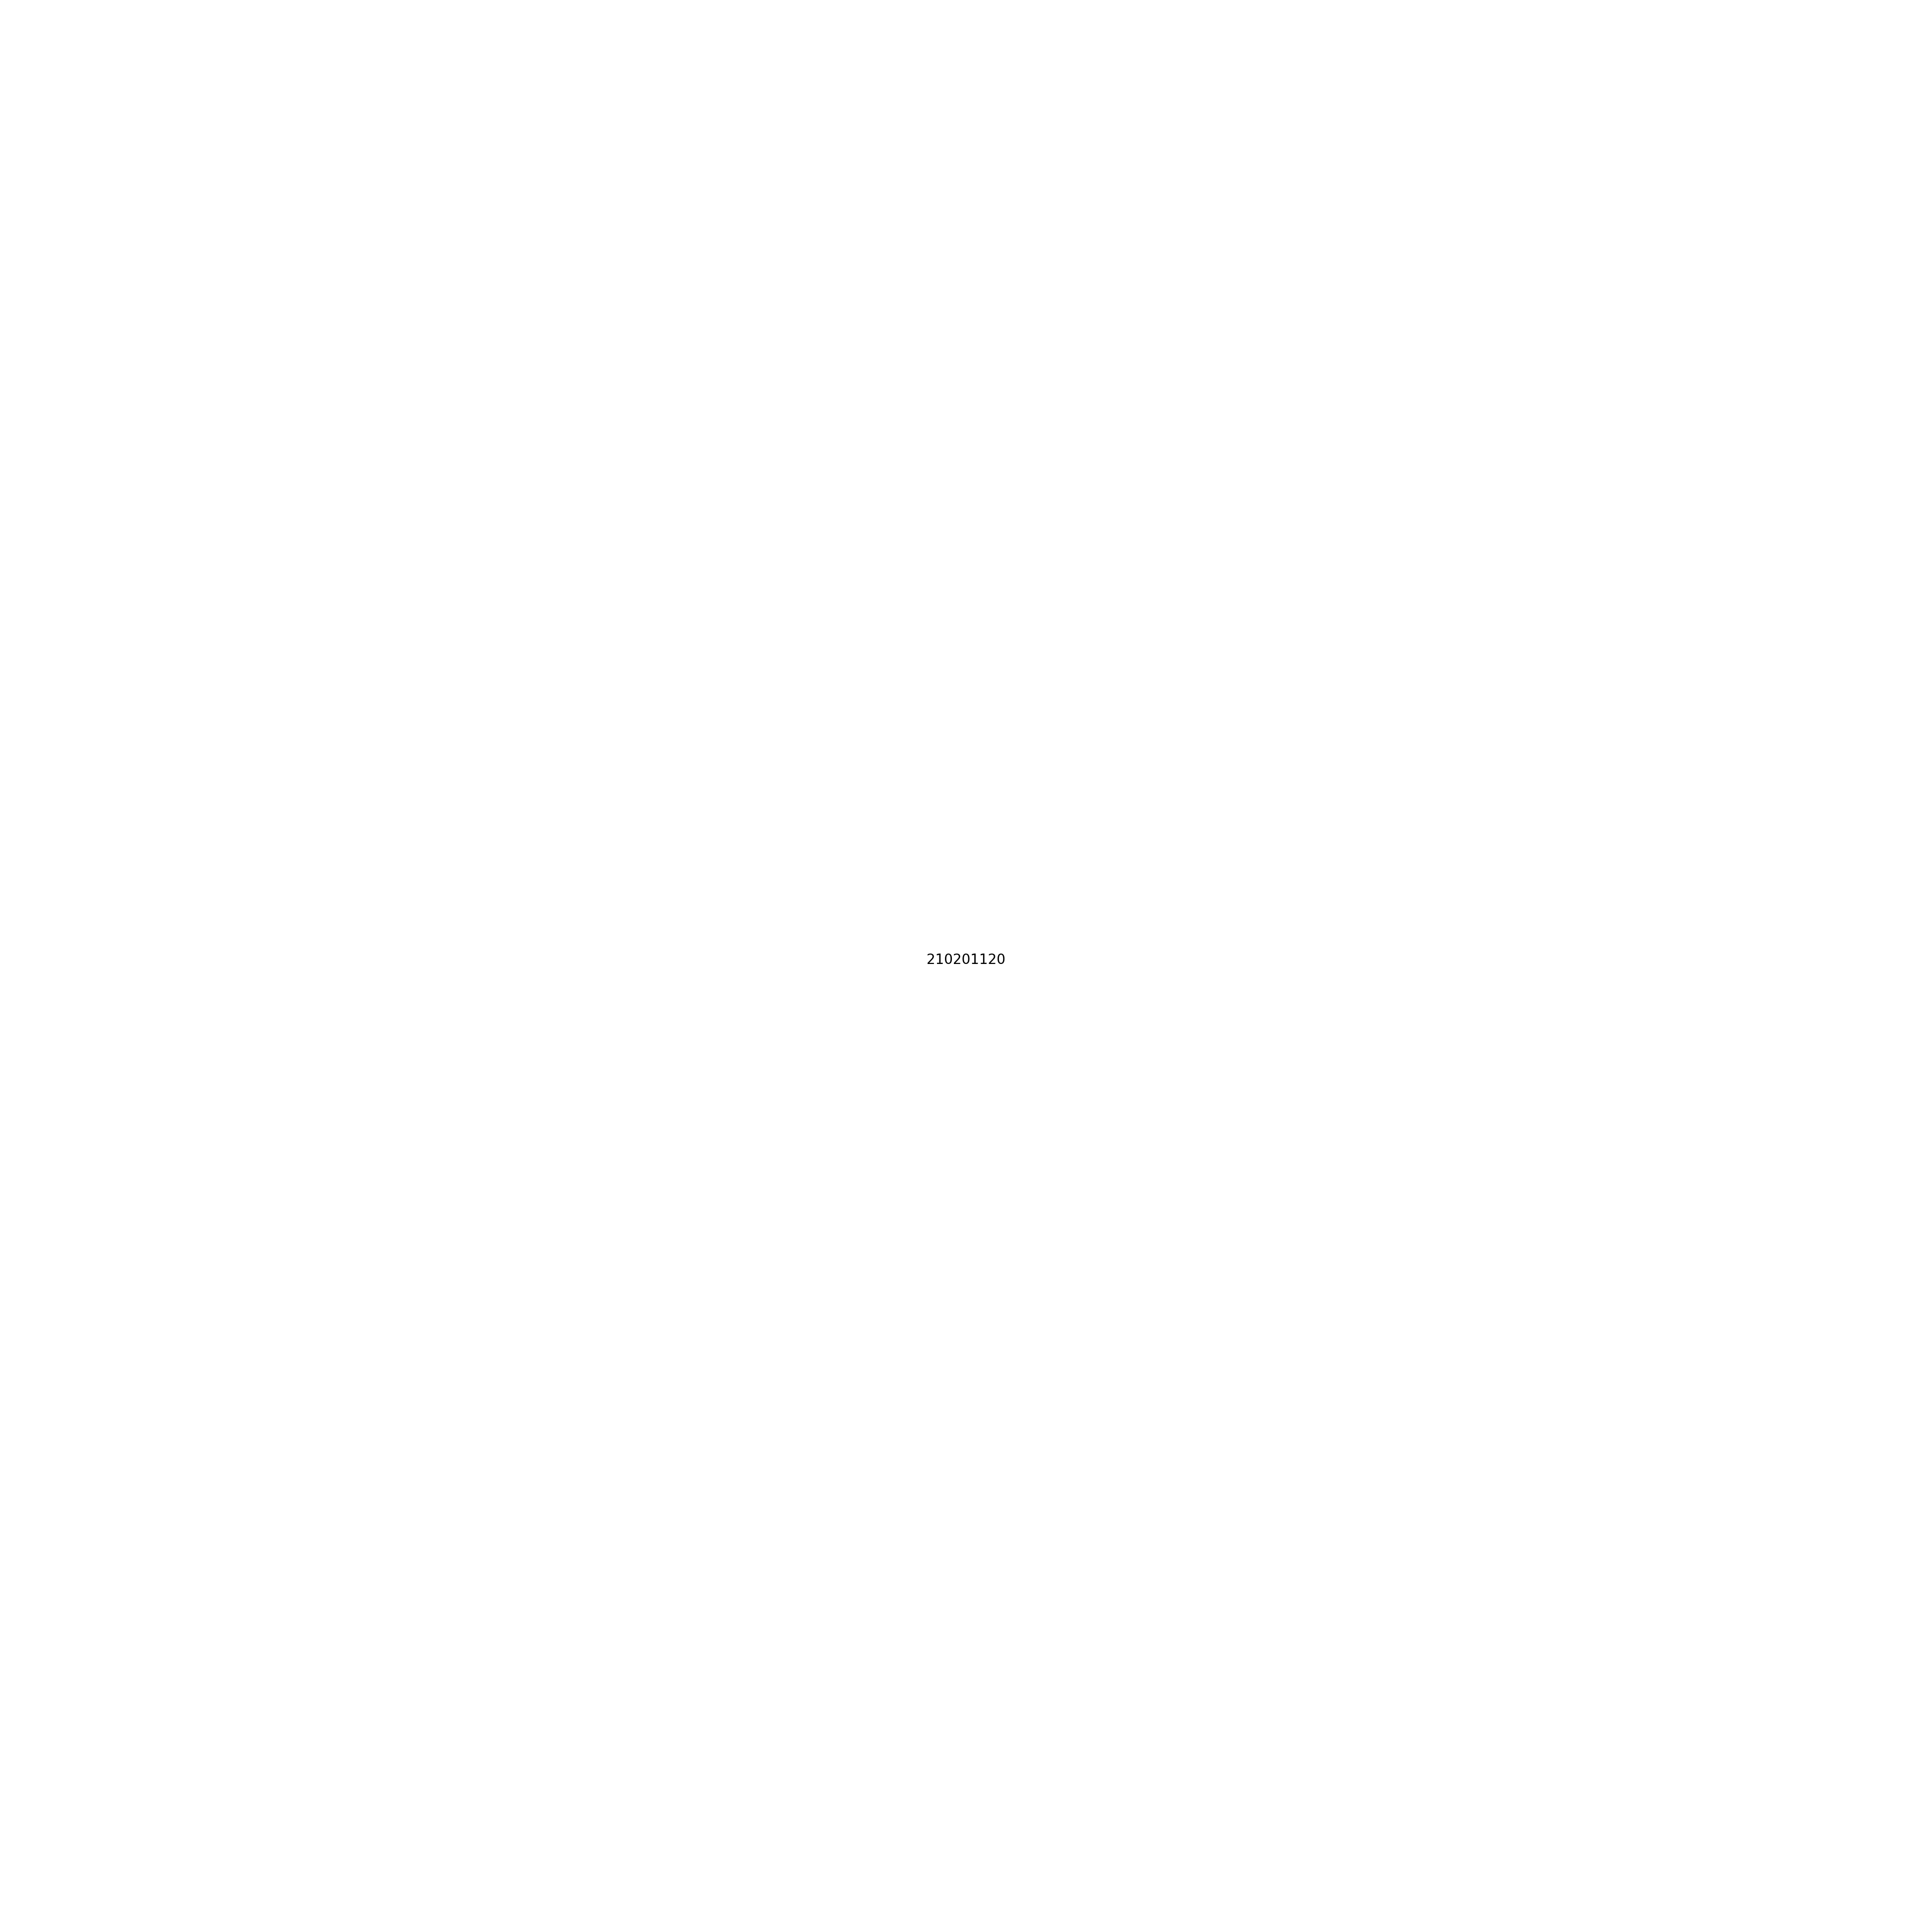

In [147]:
# get the subgraph reachable from the initial state, and the subgraph the initial state
# is reachable from
G1 = nx.ego_graph(G, '210201120', radius=20, center=True, undirected=False, distance=None)


fig = plt.figure(figsize=(50,50))
# plot the graph, do not overlap the edges, make edges directed
pos = nx.spring_layout(G1, k=0.5, iterations=50)
nx.draw_networkx_nodes(G1, pos, node_size=800, node_color='w')
nx.draw_networkx_edges(G1, pos, arrows=True, arrowstyle='->', arrowsize=20, edge_color='b', width=2)
nx.draw_networkx_labels(G1, pos, font_size=20, font_family='sans-serif')
plt.axis('off')
plt.show()


